## Hyperparams Tuner

We can configure this `HyperparamsTuner` to accomplish hyperparameter tuning and return the best hyperparameter combination. This class is designed to be used either independently, or as one of the tasks we can conduct in the inner loop of nested cross-validation. Therefore, the structure of this class is consistent with the [FeatureSelector](https://github.com/MenaWANG/ML_toy_examples/blob/main/OOP%20for%20ML%20pipeline/Building%20FeatureSelector.ipynb) class in the same repo.

Both this `HyperparamsTuner` and the [FeatureSelector](https://github.com/MenaWANG/ML_toy_examples/blob/main/OOP%20for%20ML%20pipeline/Building%20FeatureSelector.ipynb) class has a `summary_plot` which shed light on the optimizing process. For this tuner, there are two options, with the default option being parallel coordinates plot, while the user can also request for convergence plot:  

* **parallel coordinates plot** 
    * visualizes hyperparameter spaces with model performance. 
    * We can use it to explore and compare configurations of multiple hyperparameters, and 
    * identify the most effective hyperparameter combinations. <br><br>  

* **convergence plot**
    * illustrates how the performance metric changes over iterations. 
    * We can use it to diagnose whether and how the tuning converges towards optimal performance, 
    * which provides insights into the stability and effectiveness of the tuning process. <br><br>


In [32]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, make_scorer
from hyperopt import fmin, tpe, space_eval, Trials, hp
from hyperopt.pyll.base import scope
from sklearn.model_selection import StratifiedKFold
from mlops_class import MLUtils 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [51]:
class HyperparamsTuner:
    def __init__(self, 
                search_space, 
                scorer,
                max_evals=100,
                estimator=lgb.LGBMClassifier(verbose=-1),
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                random_seed = 42):
        self.scorer = scorer
        self.max_evals = max_evals
        self.search_space = search_space
        self.estimator = estimator
        self.cv = cv
        self.random_seed = random_seed
    
    def select_hyperparams(self, X, y):        
        
        def objective(params):
            
            # define the model by hyperparams
            model = self.estimator.set_params(**params)

            # split by cv and return mean test score
            scores = []
            for train_idx, valid_idx in self.cv.split(X, y):
                X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
                y_train, y_valid = y[train_idx], y[valid_idx]

                model.fit(X_train, y_train)            
                score = self.scorer(model, X_valid, y_valid)
                scores.append(score)
            
            return -np.mean(scores)  

        self.trials = Trials()    
        best = fmin(fn=objective,
                space=self.search_space,
                algo=tpe.suggest,
                max_evals=self.max_evals,
                trials=self.trials, 
                rstate=np.random.RandomState(self.random_seed))
                
        self.best_params = space_eval(self.search_space, best)
        
        return self.best_params
    
    def summary_plot(self, type = 'hyperparams'):
        """For the 1st iteration, create the convergence plot. 
        """
        if type == 'hyperparams':
            # draw parallel coordinates plot
            hyperparams = []
            metric = []

            for trial in self.trials.trials:
                # Extract hyperparameters
                trial_hyperparams = {}
                for key, values in trial['misc']['vals'].items():
                    # Convert single-item lists to scalars
                    trial_hyperparams[key] = values[0] if len(values) == 1 else values
                hyperparams.append(trial_hyperparams)        
                # Extract objective values (loss)
                metric.append(-trial['result']['loss'])

            # Create a DataFrame for plotting
            df = pd.DataFrame(hyperparams)
            df['metric'] = metric

            # Create a parallel coordinates plot
            fig = px.parallel_coordinates(df, color="metric", 
                                          color_continuous_scale=px.colors.diverging.RdYlBu[::-1])

            fig.show()  
        
        elif type == 'convergence':
            iteration = [t['tid'] for t in self.trials.trials]
            metric = [-t['result']['loss'] for t in self.trials.trials]

            plt.figure(figsize=(10, 6))
            plt.plot(iteration, metric, marker='o')
            plt.title('Convergence Plot')
            plt.xlabel('Iteration')
            plt.ylabel('Target Metric Value')
            plt.show()


In [52]:
# dataset for the demo
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# custom_scorer
custom_scorer = make_scorer(MLUtils.gini_scorer, greater_is_better=True, needs_proba=True)
search_space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 50, 1)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']),
}

# Initialize the HyperparamesTuner with the desired configuration
custom_tuner = HyperparamsTuner(search_space=search_space,
                                scorer = custom_scorer)

# Select the best hyperparams configuration
best_params = custom_tuner.select_hyperparams(X, y)
print("best_params:", best_params)


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:19<00:00,  5.10trial/s, best loss: -0.9882758737297737]
best_params: {'boosting_type': 'gbdt', 'learning_rate': 0.3231425305763935, 'n_estimators': 258, 'num_leaves': 19}


In [53]:
# by default, the tuner returns a parallel coordinates plot 
custom_tuner.summary_plot()

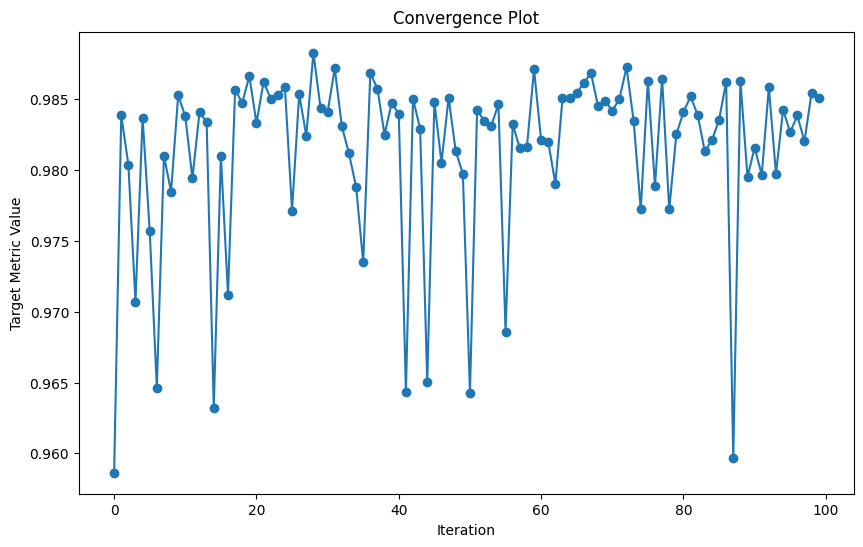

In [54]:
custom_tuner.summary_plot(type = 'convergence')

Next interation:

Add early stop mechanism to the tuner to miminize overfitting. 